In [1]:
import xspec as pyxspec
import matplotlib.pyplot as plt
import numpy as np

simulation code based on https://github.com/HEASARC/PyXspec-Jupyter-notebooks/blob/main/PyXspecWalkthrough4.ipynb

In [2]:
pyxspec.AllModels.lmod('relxill', '/home/idies/workspace/Storage/sportill/persistent/relxill')

Model package relxill successfully loaded.


In [3]:
m = pyxspec.Model('TBabs*(diskbb+relxilllpCp+xillverCp)')

 *** loading RELXILL model (version 1.4.3) *** 

Model TBabs<1>(diskbb<2> + relxilllpCp<3> + xillverCp<4>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    1.00000      +/-  0.0          
   2    2   diskbb     Tin        keV      1.00000      +/-  0.0          
   3    2   diskbb     norm                1.00000      +/-  0.0          
   4    3   relxilllpCph          GM/c^2   6.00000      +/-  0.0          
   5    3   relxilllpCpa                   0.998000     +/-  0.0          
   6    3   relxilllpCpIncl       deg      30.0000      frozen
   7    3   relxilllpCpRin                 -1.00000     frozen
   8    3   relxilllpCpRout                400.000      frozen
   9    3   relxilllpCpz                   0.0          frozen
  10    3   relxilllpCpgamma               2.00000      +/-  0.0          
  11    3   relxilllpCplogxi               3.10000      +/-  0.0          
  12    3   relxilllpCpAfe   

tbvabs Version 2.3
Cosmic absorption with grains and H2, modified from
Wilms, Allen, & McCray, 2000, ApJ 542, 914-924
Questions: Joern Wilms
joern.wilms@sternwarte.uni-erlangen.de
joern.wilms@fau.de

http://pulsar.sternwarte.uni-erlangen.de/wilms/research/tbabs/

PLEASE NOTICE:
To get the model described by the above paper
you will also have to set the abundances:
   abund wilm

Note that this routine ignores the current cross section setting
as it always HAS to use the Verner cross sections as a baseline.


In [4]:
# https://arxiv.org/pdf/1908.00965.pdf
# do h in units of the event horizon?
m.setPars({
    # TBabs
    1: 0.62, # N_H
    
    # diskbb
    2: 0.089, # kTin
    3: 2e7, # diskbb N
    
    # relxillpCp
    4: 1.6 * 2, # h
    5: 0.998, # a_*
    6: 40, # i
    7: -1.2, # R_in
    8: 1000, # R_out
    10: 1.37, # gamma
    11: 4.06, # log xi
    12: 6.5, # A_Fe
    13: 400, # kT_e
    15: 1, # fixReflFrac
    16: 0.08, # N
    
    # xillverCp
    24: 0.0015
})

# link parameters here
m(17).link = "10"
m(18).link = "12"
m(19).link = "13"
m(20).link = "11"
m(22).link = "6"


In [5]:
m.show()


Model TBabs<1>(diskbb<2> + relxilllpCp<3> + xillverCp<4>) Source No.: 1   Active/Off
Model Model Component  Parameter  Unit     Value
 par  comp
   1    1   TBabs      nH         10^22    0.620000     +/-  0.0          
   2    2   diskbb     Tin        keV      8.90000E-02  +/-  0.0          
   3    2   diskbb     norm                2.00000E+07  +/-  0.0          
   4    3   relxilllpCph          GM/c^2   3.20000      +/-  0.0          
   5    3   relxilllpCpa                   0.998000     +/-  0.0          
   6    3   relxilllpCpIncl       deg      40.0000      frozen
   7    3   relxilllpCpRin                 -1.20000     frozen
   8    3   relxilllpCpRout                1000.00      frozen
   9    3   relxilllpCpz                   0.0          frozen
  10    3   relxilllpCpgamma               1.37000      +/-  0.0          
  11    3   relxilllpCplogxi               4.06000      +/-  0.0          
  12    3   relxilllpCpAfe                 6.50000      +/-  0.0          
  

In [6]:
fs = pyxspec.FakeitSettings(response="rmfs/aciss_hetg0_cy19.rmf", arf="arfs/aciss_hetg0_cy19.arf", exposure=1e4, fileName="test.fak")

In [7]:
pyxspec.Xset.chatter = 0

In [8]:
%%timeit
pyxspec.AllData.fakeit(1, fs, noWrite=True)

26.9 ms ± 2.88 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [9]:
import scipy.stats
from sbi.inference import SNPE, prepare_for_sbi, simulate_for_sbi
from sbi import utils as utils

In [10]:
pyxspec.AllData.fakeit(1, fs, noWrite=True)
d = pyxspec.AllData(1)
energ_lo = np.array([x[0] for x in d.energies])
energ_hi = np.array([x[1] for x in d.energies])

In [11]:
# took out arf, rmf, energ_lo, energ_hi, exposure, since these are in xspec response files 
def simulate_pileup_spec(pars, frametime=3.2, tstart=0.0):
    # is frametime in response files?
    
    # pars (a_*, log xi, Gamma, h, N(xillverCp), N_H)
    m.setPars({
        # TBabs
        1: pars[5], # N_H

        # diskbb
        2: 0.089, # kTin
        3: 2e7, # diskbb N

        # relxillpCp
        4: pars[3], # h
        5: pars[0], # a_*
        6: 40, # i
        7: -1.2, # R_in
        8: 1000, # R_out
        10: pars[2], # gamma
        11: pars[1], # log xi
        12: 6.5, # A_Fe
        13: 400, # kT_e
        15: 1, # fixReflFrac
        16: 0.08, # N

        # xillverCp
        24: pars[4]
    })
    
    # simulate pileup free spectrum
    pyxspec.AllData.fakeit(1, fs, noWrite=True)
    
    exposure = pyxspec.AllData(1).exposure
    base_spec = (np.array(pyxspec.AllData(1).values) * exposure).round().astype(np.int32)

    # get the number of photons from 
    nphot = np.sum(base_spec)

    # get the end time for the exposure
    tend = tstart + exposure

    # get the photon arrival times for a constant light curve
    phot_times = np.random.uniform(tstart, tend, size=nphot)
    
    # sort the photon arrival times
    phot_times = np.sort(phot_times)
    
    # get photon energies for each photon arrival time
    phot_energies = np.random.permutation(np.repeat(energ_lo, base_spec))

    # calculate the read-out intervals, starting with the start time of the exposure
    intervals = np.arange(tstart, tend+frametime, frametime)
    
    # bin the energies according to the intervals, sum up the photon energies in eaach frame
    summed_erg, bins, bin_idx = scipy.stats.binned_statistic(phot_times, phot_energies, 
                                                             bins=intervals, statistic="sum")
    
    # only include bins where the energy is greater than zero
    # and within the bounds of the spectrum
    summed_erg = summed_erg[(summed_erg > 0) & (summed_erg < np.max(energ_hi))]
    
    # get the energy intervals in a form that I can stick them into a 
    # histogram frunction
    energ_intervals = np.hstack([energ_lo, energ_hi[-1]])

    # calculate the piled-up spectrum in counts/bin
    spec_pileup, spec_bins = np.histogram(summed_erg, bins=energ_intervals)
    
    return spec_bins, spec_pileup

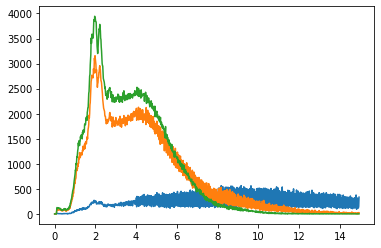

In [12]:
# pars (a_*, log xi, Gamma, h, N(xillverCp), N_H)
_, spec_pileup2 = simulate_pileup_spec([0.998, 4.06, 1.37, 3.2, 1.5e-3, 0.62], frametime=1e-2*3.2)
_, spec_pileup3 = simulate_pileup_spec([0.998, 4.06, 1.37, 3.2, 1.5e-3, 0.62], frametime=1e-3*3.2)
_, spec_pileup4 = simulate_pileup_spec([0.998, 4.06, 1.37, 3.2, 1.5e-3, 0.62], frametime=1e-4*3.2)
plt.plot(energ_lo, spec_pileup2)
plt.plot(energ_lo, spec_pileup3)
plt.plot(energ_lo, spec_pileup4)
plt.show()

In [13]:
energ_intervals = np.hstack([energ_lo, energ_hi[-1]])
# summed energy of each combination of photon energies
energ_k = (energ_lo[:, None] + energ_lo[None, :]).flatten()
idx_energ_k = np.digitize(energ_k, energ_intervals) - 1
msk_energ_k = (energ_k >= energ_intervals[0]) & (energ_k < energ_intervals[-1])
idx_energ_k = idx_energ_k[msk_energ_k]

In [14]:
from scipy.stats import poisson
from scipy.special import loggamma

# took out arf, rmf, energ_lo, energ_hi, exposure, since these are in xspec response files 
def pileup_spec_like(pars, frametime=3.2, tstart=0.0):
    # pars (a_*, log xi, Gamma, h, N(xillverCp), N_H)
    m.setPars({
        # TBabs
        1: pars[5], # N_H

        # diskbb
        2: 0.089, # kTin
        3: 2e7, # diskbb N

        # relxillpCp
        4: pars[3], # h
        5: pars[0], # a_*
        6: 40, # i
        7: -1.2, # R_in
        8: 1000, # R_out
        10: pars[2], # gamma
        11: pars[1], # log xi
        12: 6.5, # A_Fe
        13: 400, # kT_e
        15: 1, # fixReflFrac
        16: 0.08, # N

        # xillverCp
        24: pars[4]
    })
    
    pyxspec.AllData.fakeit(1, fs, applyStats=False, noWrite=True) # do NOT generate Poisson noise
    
    exposure = pyxspec.AllData(1).exposure
    base_spec = np.array(pyxspec.AllData(1).values) * exposure

    mu = np.sum(base_spec) # expected number of photons per frame
    prob_1 = base_spec.copy() / mu # distribution of photon energies
    
    # build probability distribution for piled up photon energy this frame
    # will not add to one, as there is poisson.pmf(0, mu) chance of zero photons
    pile_spec = poisson.pmf(1, mu) * prob_1.copy() # chance of one photon x one photon distribution
    
    # distribution of energies of k piled up photons, starting with k = 1
    conv_spec = prob_1.copy()
        
    # add contributions from piled up photons, starting with pairs
    k = 2
    while k < mu or poisson.pmf(k, mu) > 0.001:
        # probability of each combination of photon energies = distribution for k-1 * distribution for 1
        prob_k = (conv_spec[:, None] * prob_1[None, :]).flatten()
        
        conv_spec = np.bincount(idx_energ_k, prob_k[msk_energ_k])
        
        # summed energy of each combination of photon energies
        #energ_k = (energ_lo[:, None] + energ_lo[None, :]).flatten() # TODO: these will always fall in same energy bins
        # rebin to spectral bins
        #conv_spec, _, _ = scipy.stats.binned_statistic(energ_k, prob_k, bins=energ_intervals, statistic="sum")
        
        # add to piled up distribution
        pile_spec += poisson.pmf(k, mu) * conv_spec
        k += 1
        
    # check if observed photons have impossible energies
    if np.sum(sim_spec[pile_spec == 0]) > 0:
        print('impossible photons', np.sum(sim_spec[pile_spec == 0]), pars, mu)
        return float('-inf')
    else:
        pile_spec[pile_spec == 0] = 1e-9 # makes k * log(p) = 0 when k = 0
    
    prob_0 = 1 - np.sum(pile_spec) # chance of no photon / photon out of range
    frame_0 = (exposure // frametime) - np.sum(sim_spec) # number of empty frames
    
    assert(frame_0 >= 0)
    
    return np.sum(sim_spec*np.log(pile_spec)) + frame_0*np.log(prob_0)

bounds = [[-0.998, 0.998], [0, 4.7], [1.2, 3.4], [2, 6], [0, 3e-3], [0,2]]

class PiledLogPosterior(object):
    def logprior(self, pars):
        if np.array([pars[i] > bounds[i][0] and pars[i] < bounds[i][1] for i in range(len(pars))]).all():
            return 0
        else:
            return float('-inf')
    
    def loglikelihood(self, pars):
        return pileup_spec_like(pars, frametime=1e-3*3.2)
    
    def logposterior(self, pars):
        p = self.logprior(pars)
        if p > float('-inf'): # only call likelihood if parameters are sensible
            p += self.loglikelihood(pars)
        return p
    
    def __call__(self, pars):
        return self.logposterior(pars)

In [15]:
true_pars = [0.998, 4.06, 1.37, 3.2, 1.5e-3, 0.62]
sim_bins, sim_spec = simulate_pileup_spec(true_pars, frametime=1e-3*3.2)

In [16]:
np.save('sim_spec.npy', sim_spec)

In [17]:
%%timeit
_, _ = simulate_pileup_spec(true_pars, frametime=1e-3*3.2)

692 ms ± 30.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


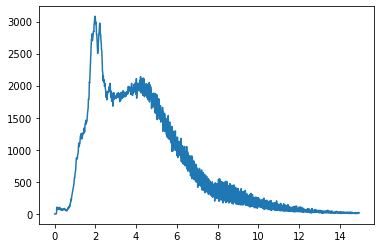

In [18]:
plt.plot(energ_lo, sim_spec)
plt.show()

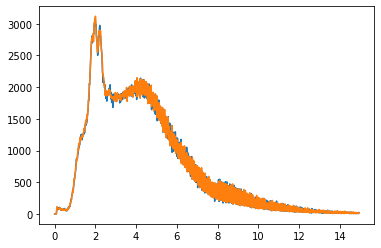

In [19]:
_, x = simulate_pileup_spec([0.998, 4.06, 1.37, 3.2, 1.5e-3, 0.62], frametime=1e-3*3.2)
plt.plot(energ_lo, sim_spec)
plt.plot(energ_lo, x)
plt.show()

In [20]:
def fixbounds(p0):
    eps = 1e-6
    for i, [lo, hi] in enumerate(bounds):
        p0[p0[:,i] < lo, i] = lo + eps
        p0[p0[:,i] > hi, i] = hi - eps
    return p0

In [21]:
import emcee

nwalkers = 100 # number of MCMC walkers
burnin = 1000 # number of burn-in steps

ndim = len(true_pars) # number of parameters

niter = 1000 # number of iterations in production

lpost = PiledLogPosterior()

In [ ]:
from multiprocessing import Pool
import os

os.environ["OMP_NUM_THREADS"] = "1"

with Pool(4) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lpost, pool=pool)
    p0 = np.random.multivariate_normal(true_pars, np.diag([0.5, 1, 0.5, 0.5, 0.5, 0.5]), size=nwalkers)
    p0 = fixbounds(p0)
    pos, prob, state = sampler.run_mcmc(p0, burnin, progress=True)
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, niter, rstate0=state, progress=True)

impossible photons 764882 [9.72945667e-01 4.65827880e+00 1.92567726e+00 2.41685776e+00
 1.00000000e-06 8.21731959e-01] 747500.5689541062
impossible photons 764882 [9.97999000e-01 2.95051231e+00 2.24611723e+00 3.44916352e+00
 2.99900000e-03 1.18587481e+00] 550856.0941202727


In [ ]:
### TODO: check out "impossible photons" spectrum

In [ ]:
from sbi import analysis as analysis

_ = analysis.pairplot(sampler.flatchain, figsize=(10,10), points=np.array(true_pars)[None,:], points_colors='r')

In [ ]:
np.save('emceeA.npy', sampler.flatchain)

In [21]:
def simulator(p):
    p = p.numpy().astype(np.float64) # why does xspec insist on float64?
    return simulate_pileup_spec(p, frametime=1e-3*3.2)[1][7:]

In [22]:
import torch
from sbi.simulators.simutils import simulate_in_batches
from tqdm import tqdm

In [24]:
prior = utils.BoxUniform(low=[x[0] for x in bounds], high=[x[1] for x in bounds])

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

posteriors = []
proposal = prior

simulation_batch_size = 1
num_workers = 1

num_rounds = 2
n_samples = 2000

x_o = sim_spec[7:]

for i in tqdm(range(num_rounds)):
    if i == 0:
        theta = prior.sample((n_samples,))
    if i > 0:
        theta = proposal.sample((n_samples,), x=x_o, show_progress_bars=False)
        
    x = simulate_in_batches(
        simulator, theta, simulation_batch_size, num_workers, False
    )
    
    density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
    posterior = inference.build_posterior(density_estimator)
    posteriors.append(posterior)
    proposal = posterior.set_default_x(x_o)

  0% 0/2 [01:20<?, ?it/s]


KeyboardInterrupt: 

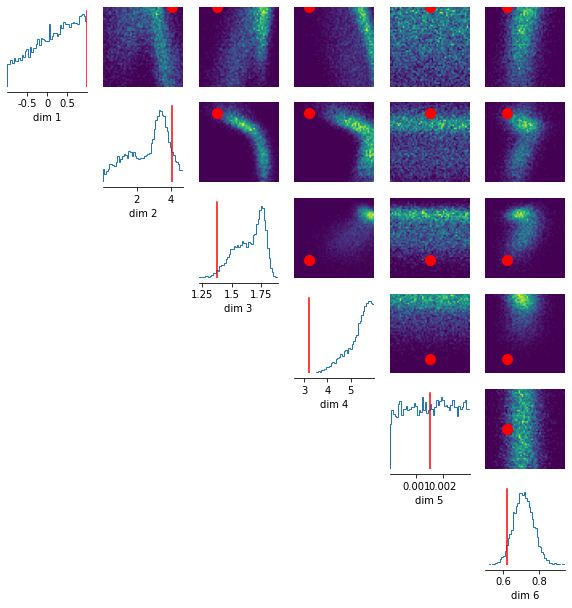

In [31]:
posterior_samples = posterior.sample((10000,), x=sim_spec[7:], show_progress_bars=False)
from sbi import analysis as analysis

# plot posterior samples
_ = analysis.pairplot(posterior_samples, figsize=(10,10), points=np.array(true_pars)[None,:], points_colors='r')

## Manually doing rounds

In [23]:
prior = utils.BoxUniform(low=[x[0] for x in bounds], high=[x[1] for x in bounds])

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)

posteriors = []
proposal = prior

simulation_batch_size = 1
num_workers = 1

n_samples = 2000

x_o = sim_spec[7:]

In [24]:
%%time
theta = prior.sample((n_samples,))
x = simulate_in_batches(
        simulator, theta, simulation_batch_size, num_workers, False
)
density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)

 *** Warning : Lamp post source too close to the black hole (h < 1.1 r_event) 
      Change to negative heights (h <= -1.1), if you want to fit in units of the Event Horizon 
      Height= 2.037  ;  r_event=1.935 
      Setting    h =  1.1*r_event  = 2.129 
 *** Warning : Lamp post source too close to the black hole (h < 1.1 r_event) 
      Change to negative heights (h <= -1.1), if you want to fit in units of the Event Horizon 
      Height= 2.037  ;  r_event=1.935 
      Setting    h =  1.1*r_event  = 2.129 
 *** Warning : Lamp post source too close to the black hole (h < 1.1 r_event) 
      Change to negative heights (h <= -1.1), if you want to fit in units of the Event Horizon 
      Height= 2.012  ;  r_event=1.984 
      Setting    h =  1.1*r_event  = 2.183 
 *** Warning : Lamp post source too close to the black hole (h < 1.1 r_event) 
      Change to negative heights (h <= -1.1), if you want to fit in units of the Event Horizon 
      Height= 2.012  ;  r_event=1.984 
      Settin

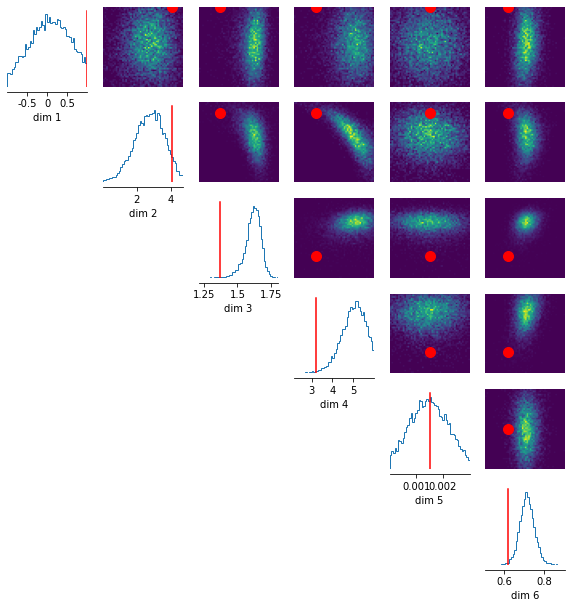

In [ ]:
posterior_samples = posterior.sample((10000,), x=sim_spec[7:], show_progress_bars=False)
from sbi import analysis as analysis

# plot posterior samples
# pars (a_*, log xi, Gamma, h, N(xillverCp), N_H)
_ = analysis.pairplot(posterior_samples, figsize=(10,10), points=np.array(true_pars)[None,:], points_colors='r')

In [ ]:
%%time
proposal = posterior.set_default_x(x_o)
theta = proposal.sample((n_samples,), x=x_o, show_progress_bars=False)
        
x = simulate_in_batches(
    simulator, theta, simulation_batch_size, num_workers, False
)

density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)
proposal = posterior.set_default_x(x_o)

Using SNPE-C with atomic loss
 Neural network successfully converged after 54 epochs.CPU times: user 6h 55min 19s, sys: 5min 21s, total: 7h 41s
Wall time: 2h 3min 8s


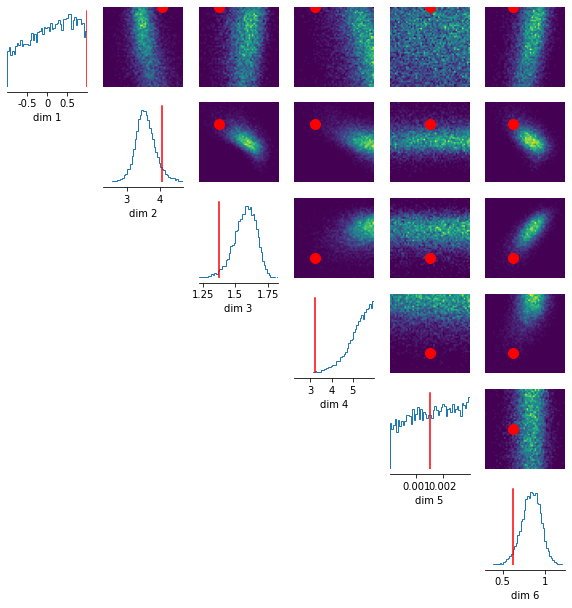

In [ ]:
posterior_samples = posterior.sample((10000,), x=sim_spec[7:], show_progress_bars=False)
from sbi import analysis as analysis

# plot posterior samples
# pars (a_*, log xi, Gamma, h, N(xillverCp), N_H)
_ = analysis.pairplot(posterior_samples, figsize=(10,10), points=np.array(true_pars)[None,:], points_colors='r')

In [35]:
%%time
proposal = posterior.set_default_x(x_o)
theta = proposal.sample((n_samples,), x=x_o, show_progress_bars=False)
        
x = simulate_in_batches(
    simulator, theta, simulation_batch_size, num_workers, False
)

density_estimator = inference.append_simulations(theta, x, proposal=proposal).train()
posterior = inference.build_posterior(density_estimator)
posteriors.append(posterior)
proposal = posterior.set_default_x(x_o)

Using SNPE-C with atomic loss
 Neural network successfully converged after 87 epochs.CPU times: user 15h 25min 32s, sys: 8min 51s, total: 15h 34min 23s
Wall time: 4h 15min 35s


                        prior support. It may take a long time to collect the
                        remaining 9956 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.


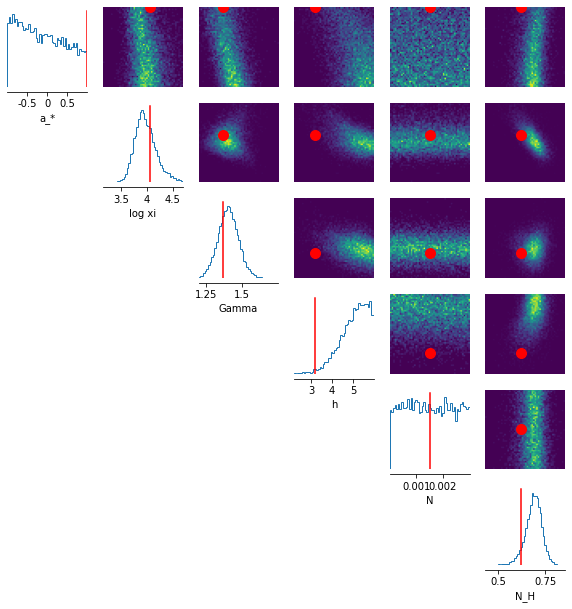

In [45]:
posterior_samples = posterior.sample((10000,), x=sim_spec[7:], show_progress_bars=False)
from sbi import analysis as analysis

# plot posterior samples
# pars (a_*, log xi, Gamma, h, N(xillverCp), N_H)
_ = analysis.pairplot(posterior_samples, figsize=(10,10), points=np.array(true_pars)[None,:], points_colors='r', labels=['a_*', 'log xi', 'Gamma', 'h', 'N', 'N_H'])

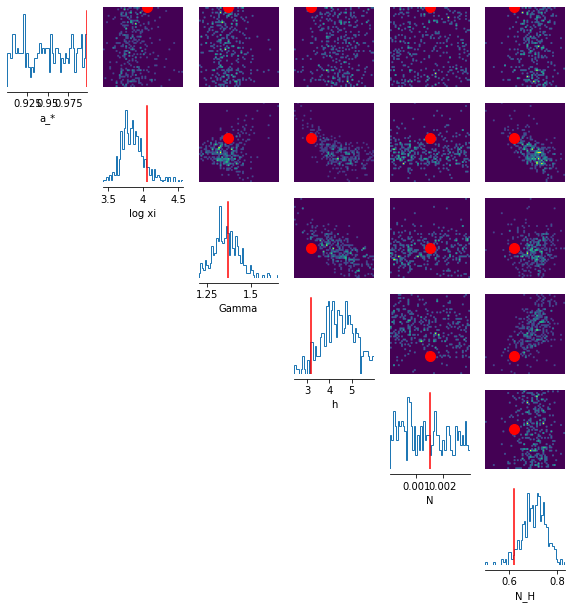

In [46]:
# pars (a_*, log xi, Gamma, h, N(xillverCp), N_H)
_ = analysis.pairplot(posterior_samples[posterior_samples[:,0] > 0.9], figsize=(10,10), points=np.array(true_pars)[None,:], points_colors='r', labels=['a_*', 'log xi', 'Gamma', 'h', 'N', 'N_H'])

In [38]:
np.save('sequentialA.npy', posterior_samples.numpy())

In [24]:
posterior_samples = np.load('sequentialA.npy')

100% 1000/1000 [12:28<00:00,  1.34it/s]


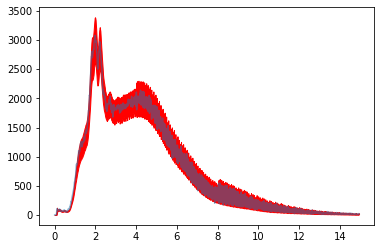

In [39]:
sim_spec_sbi = np.zeros((1000,sim_spec.size))
for i in tqdm(range(1000)):
    sim_spec_sbi[i,7:] = simulate_pileup_spec(posterior_samples[i].numpy().astype(np.float64), frametime=1e-3*3.2)[1][7:]
plt.plot(energ_lo, sim_spec, alpha=0.5)
plt.fill_between(energ_lo, np.percentile(sim_spec_sbi, 16, axis=0), np.percentile(sim_spec_sbi, 84, axis=0), fc='r', ec='r')
plt.show()

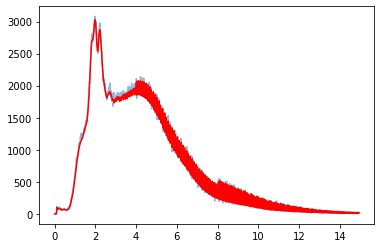

In [40]:
plt.plot(energ_lo, sim_spec, alpha=0.5)
plt.plot(energ_lo, np.mean(sim_spec_sbi, axis=0), c='r')
plt.show()

In [ ]:
print('hi')

In [11]:
%%time
prior = utils.BoxUniform(low=[-10, -2, -10, 0], high=[-3, 3, -3, 0.1])

simulator, prior = prepare_for_sbi(simulator, prior)
inference = SNPE(prior)
### AMORTIZED
theta, x = simulate_for_sbi(simulator, proposal=prior, num_simulations=10000, show_progress_bar=False) # progress bar is broken
density_estimator = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior(density_estimator)  # MCMC kwargs go here.

Neural network successfully converged after 29 epochs.
CPU times: user 7h 7min 1s, sys: 4min 26s, total: 7h 11min 27s
Wall time: 1h 57min 15s


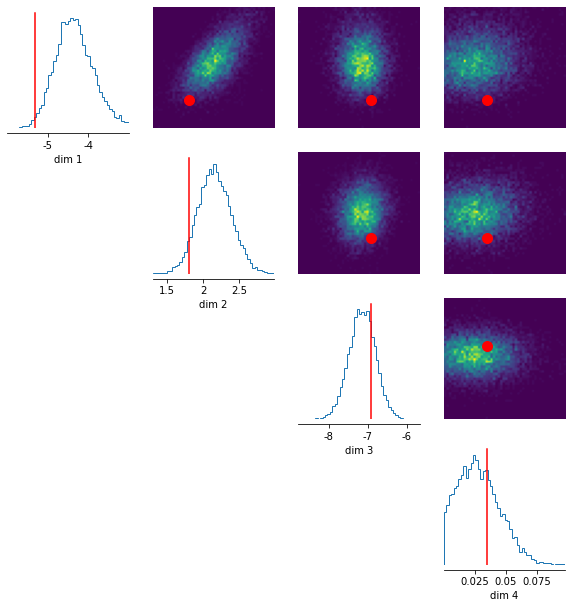

In [12]:
posterior_samples = posterior.sample((10000,), x=sim_spec[7:], show_progress_bars=False)
from sbi import analysis as analysis

# plot posterior samples
_ = analysis.pairplot(posterior_samples, figsize=(10,10), points=np.array(true_pars_lpost)[None,:], points_colors='r')

In [14]:
np.save('amortized.npy', posterior_samples.numpy())

In [16]:
from tqdm import tqdm

In [17]:
sim_spec_sbi = np.zeros((10000,sim_spec.size))
for i in tqdm(range(10000)):
    sim_spec_sbi[i,7:] = simulator(posterior_samples[i][None,:])

100% 10000/10000 [01:11<00:00, 140.35it/s]


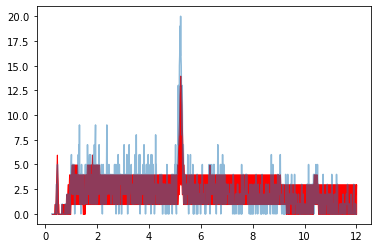

In [18]:
plt.plot(energ_lo, sim_spec, alpha=0.5)
plt.fill_between(energ_lo, np.percentile(sim_spec_sbi, 16, axis=0), np.percentile(sim_spec_sbi, 84, axis=0), fc='r', ec='r')
plt.show()

In [10]:
emcee_samples = np.load('emcee.npy')
amort_samples = np.load('amortized.npy')
seqen_samples = np.load('sequential.npy')

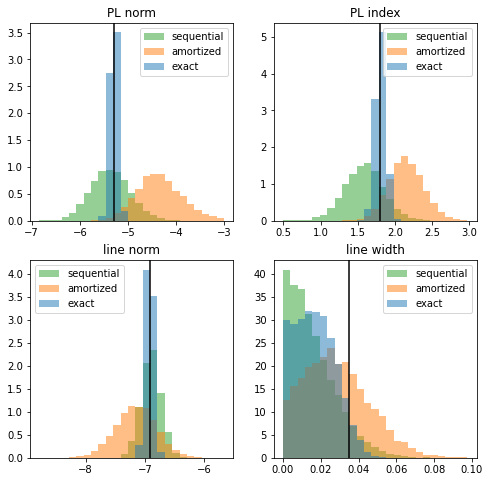

In [20]:
parameters = ['PL norm', 'PL index', 'line norm', 'line width']
plt.figure(figsize=(8,8))
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.title(parameters[i])
    plt.hist([emcee_samples[:,i], amort_samples[:,i], seqen_samples[:,i]], label=['exact', 'amortized', 'sequential'], histtype='stepfilled', alpha=0.5, density=True, bins=25)
    plt.axvline(true_pars_lpost[i], c='k')
    plt.legend()
plt.show()

In [25]:
emcee_samples.shape

(100000, 4)

In [26]:
amort_samples.shape

(10000, 4)

/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/lib/python3.7/site-packages/sbi/utils/plot.py:360: UserWarning: No contour levels were found within the data range.
  levels=opts["contour_offdiag"]["levels"],
/home/idies/miniconda3/envs/ciao/li

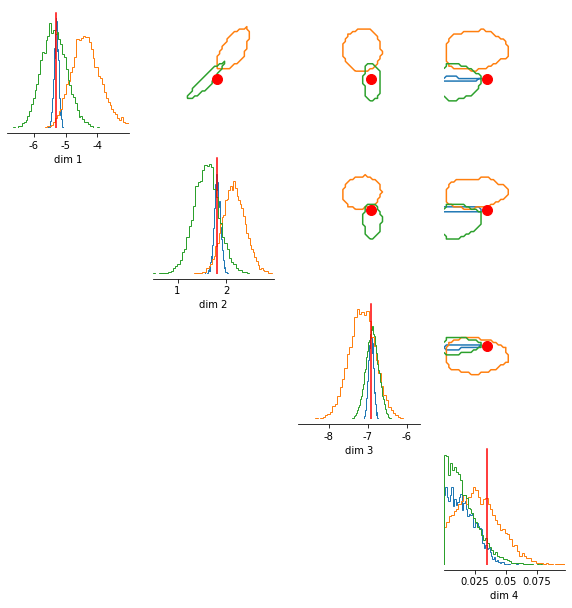

In [27]:
from sbi import analysis as analysis

# plot posterior samples
_ = analysis.pairplot([emcee_samples[::10], amort_samples, seqen_samples], figsize=(10,10), points=np.array(true_pars_lpost)[None,:], points_colors='r', upper='contour')

### Rejection Sampling

In [53]:
def from_prior():
    lognorm = np.random.uniform(-10, -3)
    phoindex = np.random.uniform(-2, 3)
    lognorm2 = np.random.uniform(-10, -3)
    sigma = np.random.uniform(0, 0.1)
    
    return [lognorm, phoindex, lognorm2, sigma]

In [54]:
def euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2)**2.))

In [59]:
prior_pars_all = np.zeros((nsims, 4))

e_dist_all = []
e_dist_accept = []

pars_all = []
pars_accept = []

nsims = 500
i=0

with tqdm(total=nsims) as pbar:
    while len(e_dist_accept) < nsims:
        p = from_prior()
        prior_pars_all[i] = p

        sim_bins, sim_spec1 = simulate_pileup_spec(p, energ_lo, energ_hi, arf, rmf, exposure=1e4)
        e_dist = euclidean_distance(sim_spec1, sim_spec)

        e_dist_all.append(e_dist)
        pars_all.append(p)

        if e_dist <= 70:
            e_dist_accept.append(e_dist)
            pars_accept.append(p)
            pbar.update(1)
            i += 1
        else:
            continue

100% 500/500 [51:13<00:00,  6.15s/it]  


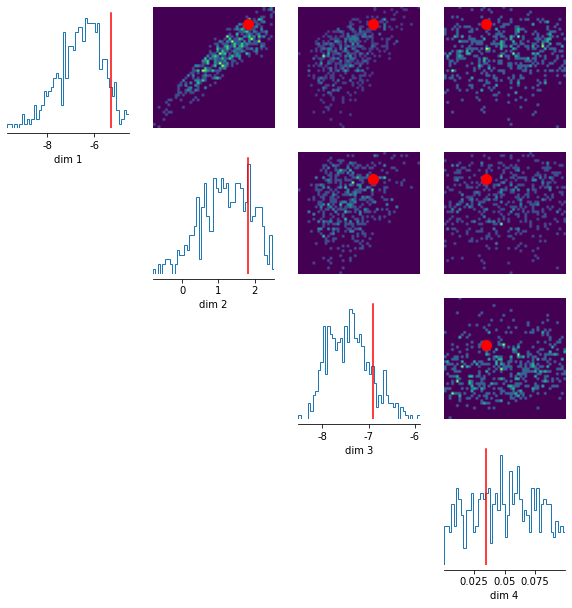

In [66]:
_ = analysis.pairplot(np.array(pars_accept), figsize=(10,10), points=np.array(true_pars_lpost)[None,:], points_colors='r')

In [67]:
500 / 0.018

27777.77777777778

In [74]:
sim_spec_rej = np.zeros((10000,sim_spec.size))
for i in tqdm(range(500)):
    sim_spec_rej[i] = simulate_pileup_spec(pars_all[i], energ_lo, energ_hi, arf, rmf, exposure=1e4)[1]

100% 500/500 [00:41<00:00, 12.15it/s]


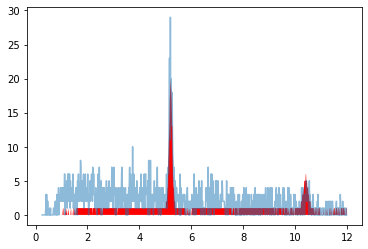

In [93]:
plt.plot(energ_lo, sim_spec, alpha=0.5)
plt.fill_between(energ_lo, np.percentile(sim_spec_rej, 1, axis=0), np.percentile(sim_spec_rej, 99, axis=0), fc='r')
plt.show()

In [113]:
density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net.context_layer.weight.shape

torch.Size([50, 1017])

In [122]:
density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net

MADE(
  (initial_layer): MaskedLinear(in_features=4, out_features=50, bias=True)
  (context_layer): Linear(in_features=1017, out_features=50, bias=True)
  (blocks): ModuleList(
    (0): MaskedFeedforwardBlock(
      (batch_norm): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (1): MaskedFeedforwardBlock(
      (batch_norm): BatchNorm1d(50, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (linear): MaskedLinear(in_features=50, out_features=50, bias=True)
      (dropout): Dropout(p=0.0, inplace=False)
    )
  )
  (final_layer): MaskedLinear(in_features=50, out_features=8, bias=True)
)

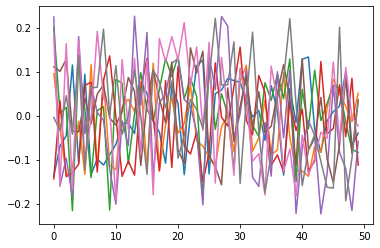

In [129]:
plt.plot(density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net.final_layer.weight.detach().T)

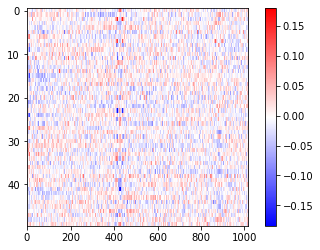

In [141]:
plt.imshow(density_estimator._transform._transforms[1]._transforms[0]._transforms[0].autoregressive_net.context_layer.weight.detach(),
           interpolation='none', aspect=20, cmap='bwr')
plt.colorbar()

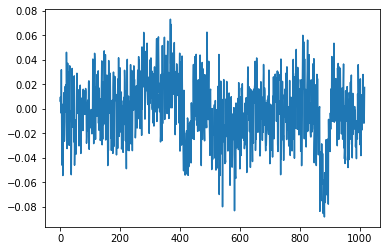

In [121]:
plt.plot(density_estimator._transform._transforms[1]._transforms[4]._transforms[0].autoregressive_net.context_layer.weight[0,:].detach())